# Tunable Hierarchical Meta Problem Tutorial

This tutorial introduces the tunable hierarchical meta problem (THiMP): a procedure for turning any non-hierarchical test problem into a hierarchical test problem with predefined characteristics. It's main usa case is to support research into hierarchical optimization algorithms by making it easy to modify certain important characteristics of the test problem while keeping other constant. This allows to study the influence of each characteristic on optimizer performance separately.

As also introduced in the [SBArchOpt Tutorial](tutorial.ipynb), architecture optimization is characterized by design variable hierarchy: some design variables may determine whether other design variables are active or not. For example, when choosing between a turbofan and a turboprop engine architecture, the bypass ratio design variable is only active if a turbofan architecture is chosen.
Ignoring this effect could lead to the optimizer evaluating different design vectors that represent the same underlying architecture, thereby wasting computational resources. The degree of hierarchy is quantified using the **imputation ratio**: the ratio between the number of declared design points to the number of valid design points. A value of 1 indicates no hierarchy, higher values indicate higher levels of hierarchy. For example, a value of 100 means that only 1% (1/100) of randomly generated design vectors actually represent a valid design vector.

Another characteristic of architecture optimization is that often some options of design variables occur much more often in the complete valid design space than others. For example, one option might deactivate many other design variables and therefore yield a "smaller" subproblem. This characteristic is quantified using **rate diversity** and can be determined by analyzing all possible (discrete) design vectors of the problem.

For example, the simple jet engine optimization problem has an imputation ratio of 3.89 (discrete imp ratio of 3.09) and a max rate diversity of 60% (shown in the table on the bottom of the statistics):

In [2]:
from sb_arch_opt.problems.turbofan_arch import SimpleTurbofanArch
SimpleTurbofanArch().print_stats()

problem: SimpleTurbofanArch()
n_discr: 6
n_cont : 9
n_obj  : 1
n_con  : 5
MD     : True
MO     : False
HIER         : True
n_valid_discr: 70
imp_ratio    : 3.89 (discrete: 3.09; continuous: 1.26)
HC           : True
failure_rate : 51%
                   x0        x3  x10  x12       x13       x14  max
inactive                         0.2  0.2  0.071429  0.071429     
opt 0             0.2  0.071429  0.4  0.4  0.357143  0.357143     
opt 1             0.8  0.285714  0.4  0.4  0.357143  0.357143     
opt 2                  0.642857            0.214286  0.214286     
diversity         0.6  0.571429  0.2  0.2  0.285714  0.285714  0.6
active-diversity  0.6  0.571429  0.0  0.0  0.153846  0.153846  0.6


The THiMP turns any non-hierarchical problem into a hierarchical problem by:
1. Defining `n_sub` sub-problems that each transform the underlying test problem in various ways (works for single- and multi-objective problems)
2. Defining hierarchical selector design variables that are used for selecting one of the sub-problems to be evaluated

The THiMP has following tunable characteristics:
- **Discrete imputation ratio**: imputation ratio of the discrete variables
- **Max rate diversity**: maximum rate diversity as seen over all discrete design variables
- **Number of sub-problems** and **nr of options for each selection variable**
- **Underlying dimensions ratio**: ratio of underlying problem dimensions and selection variables

Let's turn the continuous single-objective Branin problem into a hierarchical test problem:

In [3]:
from sb_arch_opt.problems.continuous import Branin
from sb_arch_opt.problems.hierarchical import TunableHierarchicalMetaProblem

# Define a problem factory with n (nr of dimensions) as an input (ignored for now)
branin_factory = lambda n: Branin()

hierarchical_branin = TunableHierarchicalMetaProblem(
    problem_factory=branin_factory,
    imp_ratio=1,
    n_subproblem=8,
    diversity_range=.50,
    n_opts=2,
)
hierarchical_branin.print_stats()

problem: TunableHierarchicalMetaProblem(Branin(), imp_ratio=1, n_subproblem=8, n_opts=2, diversity_range=0.5, cont_ratio=1.0)
n_discr: 4
n_cont : 2
n_obj  : 1
n_con  : 0
MD     : True
MO     : False
HIER         : True
n_valid_discr: 8
imp_ratio    : 2.00 (discrete: 2.00; continuous: 1.00)
                    x0   x1        x2    x3  max
inactive                     0.250000  0.50     
opt 0             0.75  0.5  0.500000  0.25     
opt 1             0.25  0.5  0.250000  0.25     
diversity          0.5  0.0  0.250000  0.25  0.5
active-diversity   0.5  0.0  0.333333  0.00  0.5


As you can see, the target statistics are reached quite well, however not exactly. This is because of the discrete nature of the selector variables: in the example above, the selector variables are defined with 2 options each (`n_opts`), so the imputation ratio will be some power of 2.

Some tips for creating hierarchical test problems using THiMP:
- The imputation ratio will never exceed the target imputation ratio
- Select `n_opts` such that the target imputation lies close to a power of it (except if you have some other reason to have a specific `n_opts` of course)
- Setting `n_subproblems` other than a power of `n_opts` induces a small minimum imputation ratio
- Setting `diversity_range` > 0 induces a small minimum imputation ratio
- Always run `print_stats()` on the created problem to check what characteristics are actually obtained

# Imputation Ratio and Max Rate Diversity Dependency

We can investigate what imputation ratios and max rate diversities are actually obtained for given inputs:

In [4]:
import numpy as np
imp_ratio_targets = np.logspace(0, 2, 40)
max_rate_div_targets = np.linspace(0, 1, 21)
xx, yy = np.meshgrid(imp_ratio_targets, max_rate_div_targets)

n_sub = 8
n_opts = 2

zz_ir = xx*0
zz_mrd = xx*0
for i in range(len(imp_ratio_targets)):
    for j in range(len(max_rate_div_targets)):
        prob = TunableHierarchicalMetaProblem(
            problem_factory=branin_factory,
            imp_ratio=xx[j, i],
            n_subproblem=n_sub,
            diversity_range=yy[j, i],
            n_opts=n_opts,
        )
        zz_ir[j, i] = prob.get_imputation_ratio()
        zz_mrd[j, i] = prob.get_discrete_rates()['max']['active-diversity']

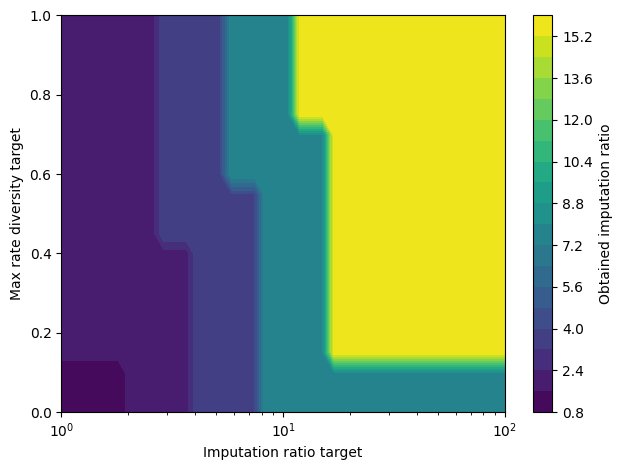

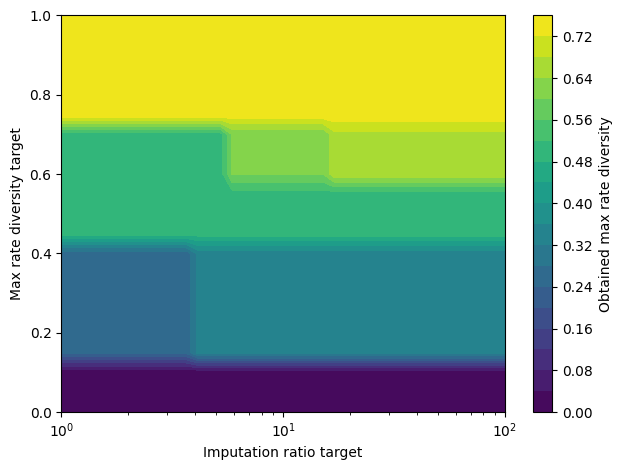

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
plt.colorbar(plt.contourf(xx, yy, zz_ir, 20)).set_label('Obtained imputation ratio')
plt.gca().set_xscale('log')
plt.xlabel('Imputation ratio target'), plt.ylabel('Max rate diversity target')
plt.tight_layout()

plt.figure()
plt.colorbar(plt.contourf(xx, yy, zz_mrd, 20)).set_label('Obtained max rate diversity')
plt.gca().set_xscale('log')
plt.xlabel('Imputation ratio target'), plt.ylabel('Max rate diversity target')
plt.tight_layout()

As can be seen from the above plots: the imputation ratio and max rate diversities can be tuned relatively independently, however there is still some interaction. So always be sure to check what characteristics are actually obtained using `print_stats()`!

# Maximum Imputation Ratio and Max Rate Diversity

To increase the maximally-obtainable imputation ratio, increase the number of subproblems:

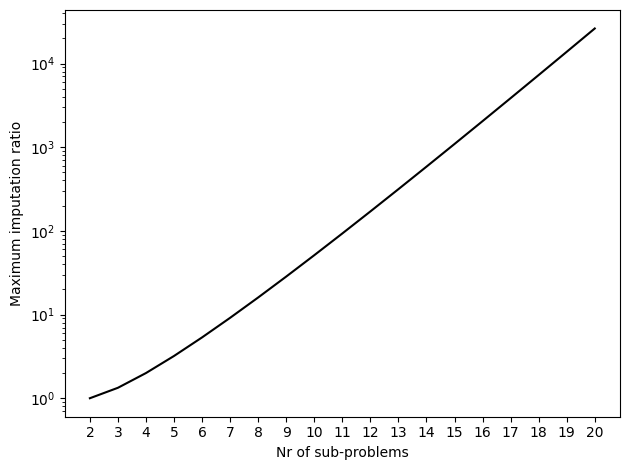

In [6]:
n_sub_test = np.arange(2, 21)
max_imp_ratios = [TunableHierarchicalMetaProblem(
    problem_factory=branin_factory,
    imp_ratio=1000000,
    n_subproblem=n_sub,
    diversity_range=1,
    n_opts=2,
).get_imputation_ratio() for n_sub in n_sub_test]

plt.figure()
plt.semilogy(n_sub_test, max_imp_ratios, '-k')
plt.xticks(n_sub_test)
plt.xlabel('Nr of sub-problems')
plt.ylabel('Maximum imputation ratio')
plt.tight_layout()

Max rate diversity will typically not rise above 85% or so. To increase it, increase the number of subproblems and reduce the number of options (at least 2):

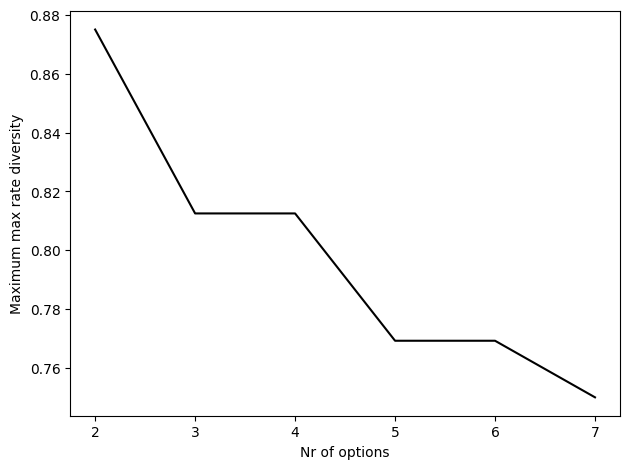

In [7]:
n_opts_test = np.arange(2, 8)
max_max_rate_div = [TunableHierarchicalMetaProblem(
    problem_factory=branin_factory,
    imp_ratio=100,
    n_subproblem=16,
    diversity_range=1,
    n_opts=n_opts,
).get_discrete_rates()['max']['active-diversity'] for n_opts in n_opts_test]

plt.figure()
plt.plot(n_opts_test, max_max_rate_div, '-k')
plt.xticks(n_opts_test)
plt.xlabel('Nr of options')
plt.ylabel('Maximum max rate diversity')
plt.tight_layout()

# Underlying-to-Selector Ratio

The final tunable characteristic is the ratio of the number of underlying design variables to the number of selector design variables.

In [8]:
from pymoo.problems.multi.zdt import ZDT1
from sb_arch_opt.problems.problems_base import NoHierarchyWrappedProblem

# We defined a factory for the ZDT1 test problem with a variable number of continuous dimensions
zdt1_factory = lambda n: NoHierarchyWrappedProblem(ZDT1(n_var=n))

# Using the cont_ratio argument you can vary the number of instantiated ZDT1 dimensions
hierarchical_zdt1 = TunableHierarchicalMetaProblem(
    problem_factory=zdt1_factory,
    imp_ratio=10,
    n_subproblem=8,
    diversity_range=.50,
    n_opts=2,
    cont_ratio=1,
)
hierarchical_zdt1.print_stats()

problem: TunableHierarchicalMetaProblem(NoHierarchyWrappedProblem(), imp_ratio=10, n_subproblem=8, n_opts=2, diversity_range=0.5, cont_ratio=1)
n_discr: 6
n_cont : 6
n_obj  : 2
n_con  : 0
MD     : True
MO     : True
HIER         : True
n_valid_discr: 8
imp_ratio    : 8.00 (discrete: 8.00; continuous: 1.00)
                    x0     x1     x2     x3        x4     x5    max
inactive                       0.750  0.500  0.625000  0.750       
opt 0             0.75  0.625  0.125  0.375  0.250000  0.125       
opt 1             0.25  0.375  0.125  0.125  0.125000  0.125       
diversity          0.5   0.25  0.625  0.375  0.500000  0.625  0.625
active-diversity   0.5   0.25  0.000  0.500  0.333333  0.000    0.5


In [9]:
TunableHierarchicalMetaProblem(
    problem_factory=zdt1_factory,
    imp_ratio=10,
    n_subproblem=8,
    diversity_range=.50,
    n_opts=2,
    cont_ratio=.5,  # Reduce the number of ZDT1 dimensions
).print_stats()

problem: TunableHierarchicalMetaProblem(NoHierarchyWrappedProblem(), imp_ratio=10, n_subproblem=8, n_opts=2, diversity_range=0.5, cont_ratio=0.5)
n_discr: 6
n_cont : 3
n_obj  : 2
n_con  : 0
MD     : True
MO     : True
HIER         : True
n_valid_discr: 8
imp_ratio    : 8.00 (discrete: 8.00; continuous: 1.00)
                    x0     x1     x2     x3        x4     x5    max
inactive                       0.750  0.500  0.625000  0.750       
opt 0             0.75  0.625  0.125  0.375  0.250000  0.125       
opt 1             0.25  0.375  0.125  0.125  0.125000  0.125       
diversity          0.5   0.25  0.625  0.375  0.500000  0.625  0.625
active-diversity   0.5   0.25  0.000  0.500  0.333333  0.000    0.5


# Sub-problem Output Transformations

The sub-problems define the objective outputs of the underlying problem (note: constraint functions are not touched).

For example, the hierarchical Branin problem (single-objective) is transformed as follows:

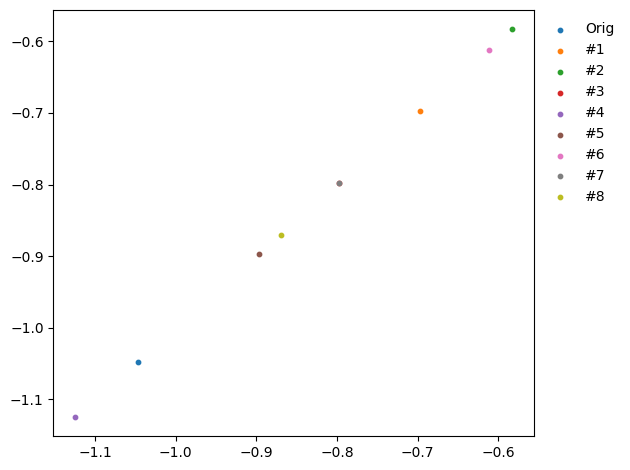

In [10]:
hierarchical_branin.plot_transformation()

As can be seen, each sub-problem has a different associated optimum point.
We can also determine which sub-problem contains the global optimum (compare the result with the previous plot):

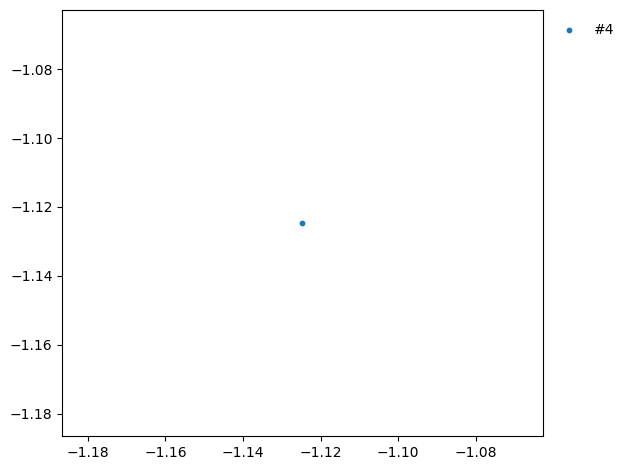

In [11]:
hierarchical_branin.plot_i_sub_problem()

For multi-objective problem the Pareto fronts are transformed in multiple dimensions:

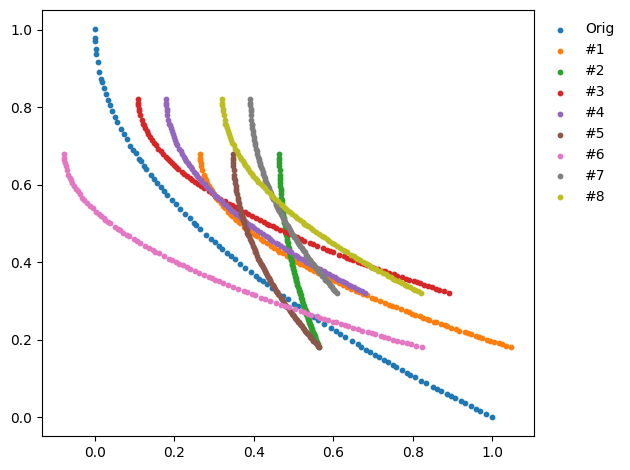

In [12]:
hierarchical_zdt1.plot_transformation()

And now the combined Pareto front can be plotted:

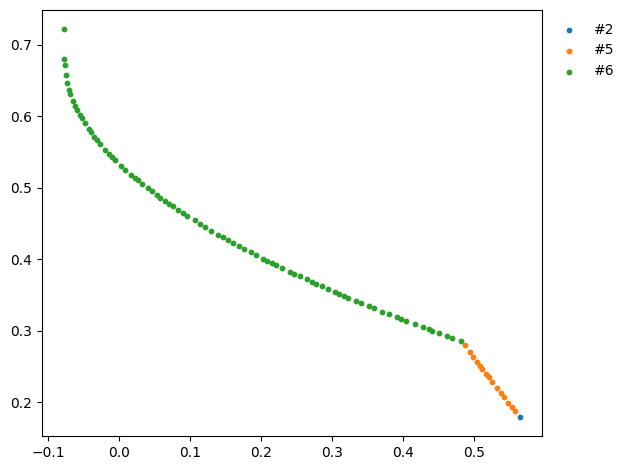

In [13]:
hierarchical_zdt1.plot_i_sub_problem()